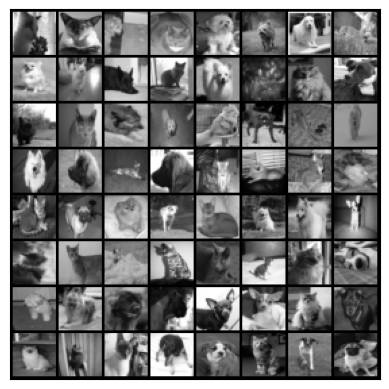

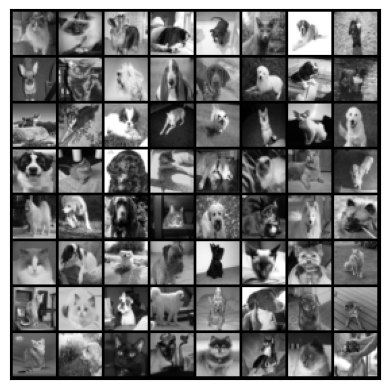

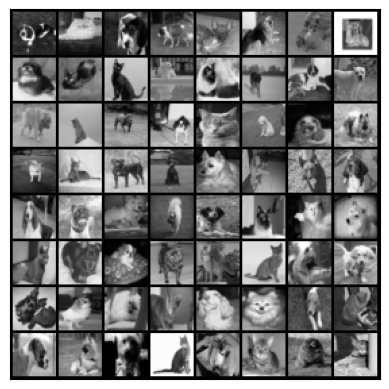

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

import torchvision
import torchvision.datasets as dset
from torchvision import transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt


# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 28

batch_size = 16

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 28

# Size of feature maps in discriminator
ndf = 28

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

batch_size = 64


device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")

import os
if not os.path.exists('data'):
    os.makedirs('data')

import ssl
ssl._create_default_https_context = ssl._create_unverified_context


import utils

train_dl = utils.get_training_dl("data/pets", "pets", batch_size=batch_size, image_size=32,  nc=nc, mean=0.5, std=0.5)

for i, (images, categories) in enumerate(train_dl, 0):
    utils.display_grid(images)
    if(i == 2):
        break


In [24]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    # print(classname)
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
    print(nn.init.normal_)

In [25]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z (nz * 1 * 1), going into a convolution
            nn.ConvTranspose2d( in_channels=nz, out_channels=ngf * 2, kernel_size= 8, stride = 1, padding = 0, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),

            # input to layer below - 64 * 8 * 8
            nn.ConvTranspose2d(in_channels = ngf * 2, out_channels=ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            # input to layer below - 32 * 16 * 16
            nn.ConvTranspose2d( in_channels=ngf, out_channels=nc, kernel_size=2, stride = 2, padding = 0, bias=False),
            
            # input to layer below - 1 * 32 * 32
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# create and test the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

noise = torch.randn(batch_size, nz, 1, 1)

G_out = netG(noise)
print(G_out.shape)


<function normal_ at 0x1116309a0>
<function normal_ at 0x1116309a0>
<function normal_ at 0x1116309a0>
<function normal_ at 0x1116309a0>
<function normal_ at 0x1116309a0>
<function normal_ at 0x1116309a0>
<function normal_ at 0x1116309a0>
<function normal_ at 0x1116309a0>
<function normal_ at 0x1116309a0>
<function normal_ at 0x1116309a0>
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 56, kernel_size=(8, 8), stride=(1, 1), bias=False)
    (1): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(56, 28, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(28, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(28, 1, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (7): Tanh()
  )
)
torch.Size([64, 1, 32, 32])


In [26]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 32 x 32``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 16 x 16``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 8 x 8``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 4 x 4``
            nn.Conv2d(ndf * 4, 1, 3, 2, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
# print(netD)


noise = torch.randn(batch_size, nz, 1, 1)

G_out = netG(noise)
print(G_out.shape)
D_out = netD(G_out)
print(D_out.shape)


<function normal_ at 0x1116309a0>
<function normal_ at 0x1116309a0>
<function normal_ at 0x1116309a0>
<function normal_ at 0x1116309a0>
<function normal_ at 0x1116309a0>
<function normal_ at 0x1116309a0>
<function normal_ at 0x1116309a0>
<function normal_ at 0x1116309a0>
<function normal_ at 0x1116309a0>
<function normal_ at 0x1116309a0>
<function normal_ at 0x1116309a0>
<function normal_ at 0x1116309a0>
torch.Size([64, 1, 32, 32])
torch.Size([64, 1, 1, 1])


In [27]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [28]:
# Training Descriminator + Generator together

# Lists to keep track of progress
img_list = []
D_losses = []
G_losses = []
iters = 0

print("Starting Training Loop...")

for epoch in range(num_epochs):
    for i, real_images in enumerate(train_dl, 0):
        netD.zero_grad()

        # print("Training Discriminator with Real Images..")

        # get output of discriminator by passing real_images through it
        real_img_device = real_images[0].to(device)
        batch_size = real_img_device.size(0)
        D_out_real = netD(real_img_device).view(-1)

        # calculate descriminator loss
        real_labels = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        D_loss_real = criterion(D_out_real, real_labels)

        # compute gradients in backward pass
        D_loss_real.backward()

        # calculate mean of Descriminator output for real images
        D_x= D_out_real.mean().item()

        # print("Training Discriminator with Fake Images..")

        # generate a batch of latent vectors of size nz
        latent_vectors = torch.randn(batch_size, nz, 1, 1, device=device)
        # pass the latent noise through Generator to generate fake images
        fake_images = netG(latent_vectors)

        # pass the generated fake images through discriminator and get the output
        D_out_fake = netD(fake_images.detach()).view(-1)

        # calculate mean of Descriminator output for fake images
        D_G_z1 = D_out_fake.mean().item()

        # calculate descriminator loss
        fake_labels = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)
        D_loss_fake = criterion(D_out_fake, fake_labels)

        # compute gradients in backward pass
        D_loss_fake.backward()

        # compute total discriminator loss and add it to D_losses list
        D_loss = D_loss_real + D_loss_fake
        D_losses.append(D_loss.item())

        # update the gradients
        optimizerD.step()

        
        # print("Training Generator....")
        netG.zero_grad()
        out = netD(fake_images).view(-1)
        G_loss = criterion(out, real_labels)
        G_loss.backward()
        G_losses.append(G_loss.item())
        D_G_z2 = out.mean().item()
        optimizerG.step()


        if i % 50 == 0:
            print(' Epoch:%d  Batch:%d  D_loss: %.4f G_loss: %.4f D_x: %.4f D_G_z1: %.4f D_G_z2: %.4f'
                  % (epoch, i, D_loss.item(), G_loss.item(), D_x, D_G_z1, D_G_z2))
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 100 == 0) or ((epoch == num_epochs-1) and (i == len(train_dl)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
                img_list.append(make_grid(fake, padding=2, normalize=True))
        iters += 1

Starting Training Loop...
 Epoch:0  Batch:0  D_loss: 1.4371 G_loss: 0.9067 D_x: 0.4705 D_G_z1: 0.4781 D_G_z2: 0.4152
 Epoch:0  Batch:50  D_loss: 0.2329 G_loss: 2.9651 D_x: 0.8995 D_G_z1: 0.1111 D_G_z2: 0.0619
 Epoch:1  Batch:0  D_loss: 0.1219 G_loss: 3.7917 D_x: 0.9531 D_G_z1: 0.0685 D_G_z2: 0.0311
 Epoch:1  Batch:50  D_loss: 0.0490 G_loss: 3.9875 D_x: 0.9651 D_G_z1: 0.0128 D_G_z2: 0.0270
 Epoch:2  Batch:0  D_loss: 2.1382 G_loss: 0.0591 D_x: 0.2698 D_G_z1: 0.0010 D_G_z2: 0.9431
 Epoch:2  Batch:50  D_loss: 0.2503 G_loss: 1.8923 D_x: 0.8392 D_G_z1: 0.0588 D_G_z2: 0.1729
 Epoch:3  Batch:0  D_loss: 0.2617 G_loss: 3.0272 D_x: 0.8728 D_G_z1: 0.0821 D_G_z2: 0.0626
 Epoch:3  Batch:50  D_loss: 0.2997 G_loss: 1.8497 D_x: 0.8566 D_G_z1: 0.1213 D_G_z2: 0.1689
 Epoch:4  Batch:0  D_loss: 0.4060 G_loss: 1.9207 D_x: 0.8170 D_G_z1: 0.1642 D_G_z2: 0.1685
 Epoch:4  Batch:50  D_loss: 0.6538 G_loss: 2.9292 D_x: 0.8713 D_G_z1: 0.3654 D_G_z2: 0.1162
 Epoch:5  Batch:0  D_loss: 0.6209 G_loss: 1.5706 D_x: 0.750

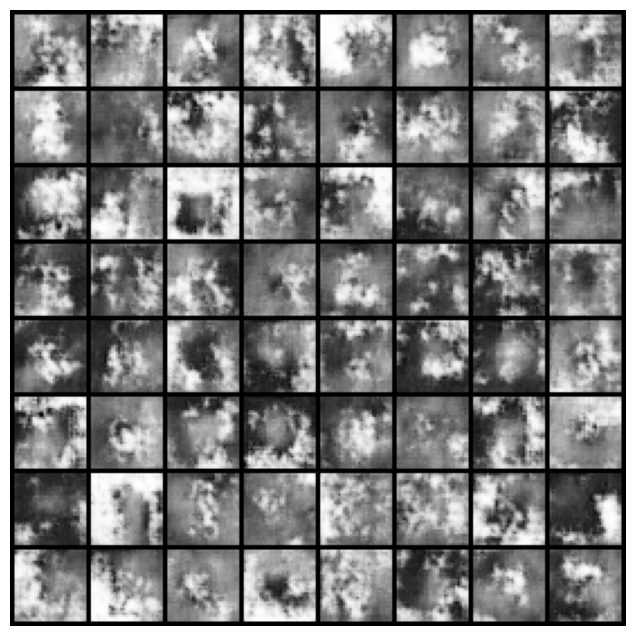

In [29]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

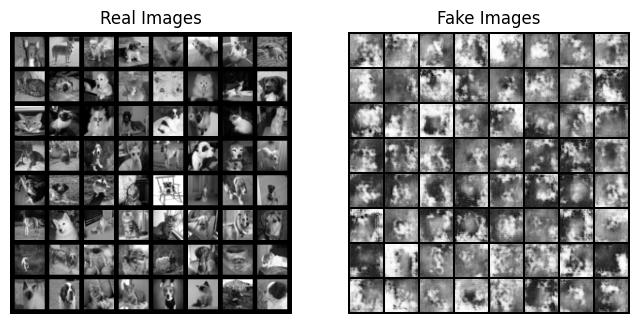

In [30]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dl))

# Plot the real images
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(make_grid(real_batch[0].to(device)[:batch_size], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

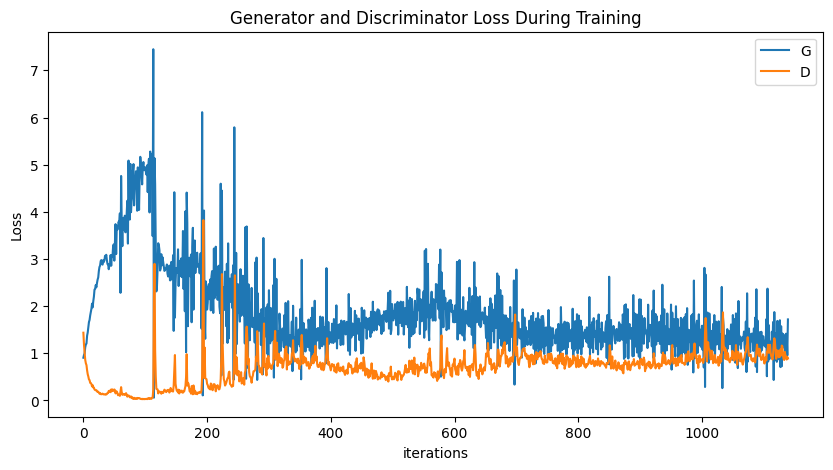

In [32]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()